### Metropolis Within Gibbs Algorithm

### Import the necessary libraries

In [260]:
import numpy as np
import matplotlib.pyplot as plt

### Install this package it will be useful later

In [261]:
!pip install tabulate

### This is a helping function that calculates the conditional probabilities

In [262]:
def conditional_sampler(sampling_index, current_x, mean, cov):

    conditioned_indices = [i for i in range(3) if i != sampling_index]

    # example for μ0
    a = cov[sampling_index, sampling_index] # Σ00
    b = cov[sampling_index, conditioned_indices] # Σ01, Σ02
    c = cov[conditioned_indices, sampling_index] # Σ10, Σ20
    d = cov[conditioned_indices, conditioned_indices] # Σ11, Σ22
    e = mean[conditioned_indices] # μ1, μ2
    t_i = current_x[conditioned_indices] # t1, t2

    s_yx = np.array([[b[0], b[1]]]) # [Σ01 Σ02]
    s_xx_inv = np.linalg.inv(cov[conditioned_indices, :][:, conditioned_indices]) # [Σ11 Σ12
                                                                                  #  Σ21 Σ22]
    s_xy = np.array([[c[0]], [c[1]]]) # [Σ10
                                      #  Σ20]
    mx = np.array([[t_i[0] - e[0]], [t_i[1] - e[1]]]) # [t_1 - mean[1]
                                                      #  t_2 - mean[2]]
    mu = mean[sampling_index] + s_yx @ s_xx_inv @ mx
    sigma = np.sqrt(a - s_yx @ s_xx_inv @ s_xy)

    new_x = np.copy(current_x) # copy the vector [t_0, t_1, t_2]
    new_x[sampling_index] = np.random.randn() * sigma[0][0] + mu[0] # replace t_0 with t_0'

    return new_x

### Define q(x)

In [263]:
# define the proposal distribution
def q(x, cov = 1):
    '''
    Random proposition for the Metropolis-Hastings algorithm.
    Uses the multivariate normal distribution with mean x and covariance cov.

    x -- np array of size k
    '''
    return np.random.normal(x, cov)

### Define π(x)

In [264]:
def pi(x, mean, x0, cov):
    '''

    Density of the target distribution, up to a constant.

    x -- np array of size k
    V -- np array of size k*k
    '''
    conditioned_indices = [0,2]

    # example for μ0
    a = cov[1, 1] # Σ00
    b = cov[1, conditioned_indices] # Σ01, Σ02
    c = cov[conditioned_indices, 1] # Σ10, Σ20
    d = cov[conditioned_indices, conditioned_indices] # Σ11, Σ22
    e = mean[conditioned_indices] # μ1, μ2
    t_i = x0[conditioned_indices] # t1, t2

    s_yx = np.array([[b[0], b[1]]]) # [Σ01 Σ02]
    s_xx_inv = np.linalg.inv(cov[conditioned_indices, :][:, conditioned_indices]) # [Σ11 Σ12
                                                                                  #  Σ21 Σ22]
    s_xy = np.array([[c[0]], [c[1]]]) # [Σ10
                                      #  Σ20]
    mx = np.array([[t_i[0] - e[0]], [t_i[1] - e[1]]]) # [t_1 - mean[1]
                                                      #  t_2 - mean[2]]
    mu = mean[1] + s_yx @ s_xx_inv @ mx
    sigma = np.sqrt(a - s_yx @ s_xx_inv @ s_xy)

    return np.e**(-0.5*(((x-mu)/sigma)**2))

### The random walk metropolis function

In [265]:
def random_walk_metropolis(pi, q, x0, mean, cov):
    x = x0[1]
    chain = np.zeros([1, 3])
    y = q(x)
    ratio = pi(y, mean, x0, cov)/pi(x, mean, x0, cov)
    a = np.min([1.,ratio[0][0]])
    r = np.random.rand()
    if r < a:
        x = y
    x0[1] = x
    return x0

### The Gibbs sampler function

In [266]:
def gibbs_sampler(initial_point, num_samples, mean, cov, burn_in, thinning):

    point = np.array(initial_point)
    samples = np.zeros((num_samples+1, 3))  # sampled points

    sample_counter = 0
    counter = 0
    while sample_counter < num_samples:

        # Sample from p(t_0|t_1, t_2)
        temp_point = conditional_sampler(0, point, mean, cov)

        # Sample using Metropolis
        temp_point = random_walk_metropolis(pi, q, temp_point, mean, cov)

        # Sample from p(t_2|t_0', t_1')
        point = conditional_sampler(2, temp_point, mean, cov)

        # Save the sample using burn_in and thinning
        if counter > burn_in and (counter-burn_in) % thinning == 0:
            samples[sample_counter] = point
            sample_counter += 1

        counter += 1

    return samples

### Define the mean/cov and the rest of the arguments to start the simulation

In [267]:
mean = np.array([1, 2 ,-1]).T
cov = np.array([[1, 0.95, 0.3],
                [0.95, 2, 0.9],
                [0.3, 0.9, 3]])
initial_point = [-57.7, 8.3, 94.46]
num_samples = 1000
burn_in = 200
thinning = 8

samples = gibbs_sampler(initial_point, num_samples, mean, cov, burn_in, thinning)
sample_mean = np.mean(samples, axis = 0)
sample_std = np.std(samples, axis = 0)

print("The simulated mean is: {}".format(np.around(sample_mean, decimals=2)))

print("The simulated standard deviation is: {}".format(np.around(sample_std, decimals=2)))

The simulated mean is: [ 1.08  2.09 -1.08]
The simulated standard deviation is: [1.   1.37 1.71]


### Plot the chain for each dimension in order to visually spot a good burn-in value

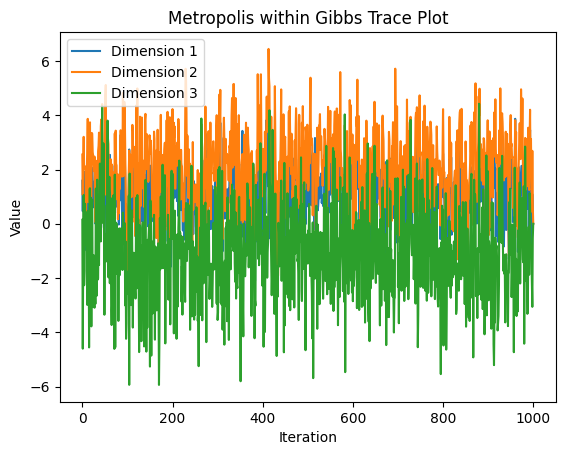

In [272]:
for i in range(samples.shape[1]):
    plt.plot(samples[:, i], label=f"Dimension {i+1}")

# Add labels and legend
plt.title("Metropolis within Gibbs Trace Plot")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

### Plot the covariance ellipsoid

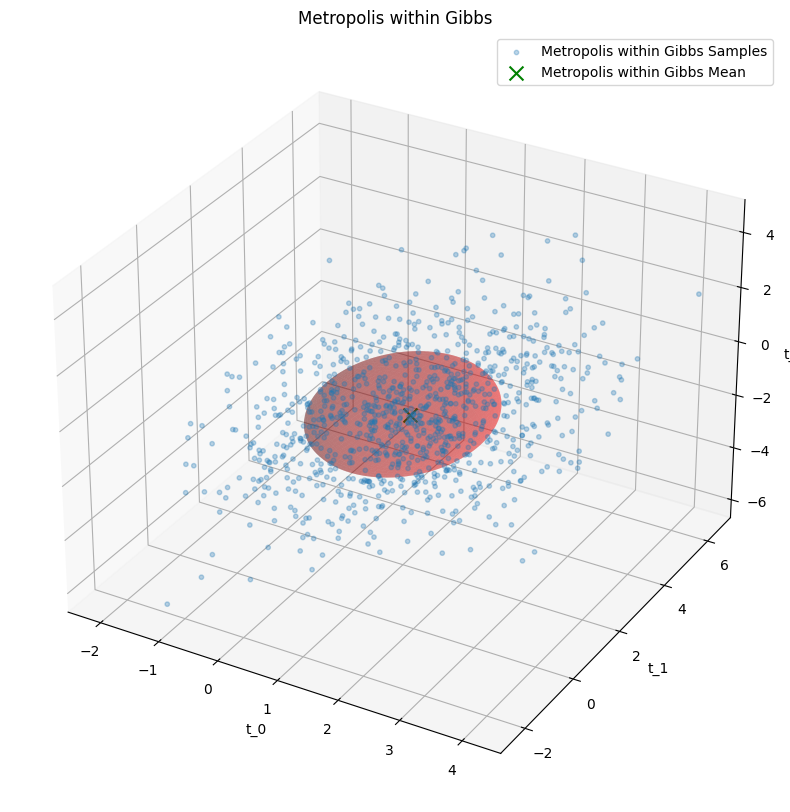

In [269]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# plot Gibbs samples
ax.scatter(samples[:,0], samples[:,1], samples[:,2], s=10, alpha=0.3, label='Metropolis within Gibbs Samples')

# plot Gibbs mean
ax.scatter(sample_mean[0], sample_mean[1], sample_mean[2], s=100, marker='x', color='g', label='Metropolis within Gibbs Mean')

# plot covariance ellipsoid
eig_vals, eig_vecs = np.linalg.eig(cov)
radii = np.sqrt(eig_vals)
u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)
x = radii[0] * np.outer(np.cos(u), np.sin(v))
y = radii[1] * np.outer(np.sin(u), np.sin(v))
z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
for i in range(len(x)):
    for j in range(len(x)):
        [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], eig_vecs) + mean
ax.plot_surface(x, y, z, alpha=0.3, color='r')

# add labels and legend
ax.set_xlabel('t_0')
ax.set_ylabel('t_1')
ax.set_zlabel('t_2')
ax.set_title('Metropolis within Gibbs')
plt.legend()

plt.show()

### Calculate the effective size, which also helps to tune thinning

In [270]:
#import tensorflow_probability as tfp
#import tensorflow as tf

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#ess = tfp.mcmc.effective_sample_size(samples)[0]

#print(int(ess.numpy()))

### Final Results

In [271]:
from tabulate import tabulate

# Your data
data = [["Mean", "1.03, 1.96, -0.98", "1.04, 2.06, -0.94", "1.01, 2.03, -1"],
        ["Standard Deviation", "1.03, 1.42, 1.7", "0.95, 1.38, 1.63", "0.96, 1.33, 1.72"],
        ["ESS", "802", "563", "646"]]

# Column names
headers = ['', 'Gibbs', 'Metropolis', 'Metropolis+Gibbs']

# Print table with headers
print(tabulate(data, headers=headers))

                    Gibbs              Metropolis         Metropolis+Gibbs
------------------  -----------------  -----------------  ------------------
Mean                1.03, 1.96, -0.98  1.04, 2.06, -0.94  1.01, 2.03, -1
Standard Deviation  1.03, 1.42, 1.7    0.95, 1.38, 1.63   0.96, 1.33, 1.72
ESS                 802                563                646
